[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Loading dataset...
Loading books.csv from: /root/.cache/kagglehub/datasets/saurabhbagchi/books-dataset/versions/1/books_data/books.csv


<ipython-input-14-9af18701eb2f>:40: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books_df = pd.read_csv(



Dataset loaded successfully!
Number of books: 271360

First few rows:
         ISBN                                         Book-Title  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
4  0393045218                             The Mummies of Urumchi   

            Book-Author Year-Of-Publication                   Publisher  \
0    Mark P. O. Morford                2002     Oxford University Press   
1  Richard Bruce Wright                2001       HarperFlamingo Canada   
2          Carlo D'Este                1991             HarperPerennial   
3      Gina Bari Kolata                1999        Farrar Straus Giroux   
4       E. J. W. Barber                1999  W. W. Norton &amp; Company   

                                         Image-URL-S  \
0  http://ima

<ipython-input-14-9af18701eb2f>:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_df['Year-Of-Publication'] = books_df['Year-Of-Publication'].astype(int)


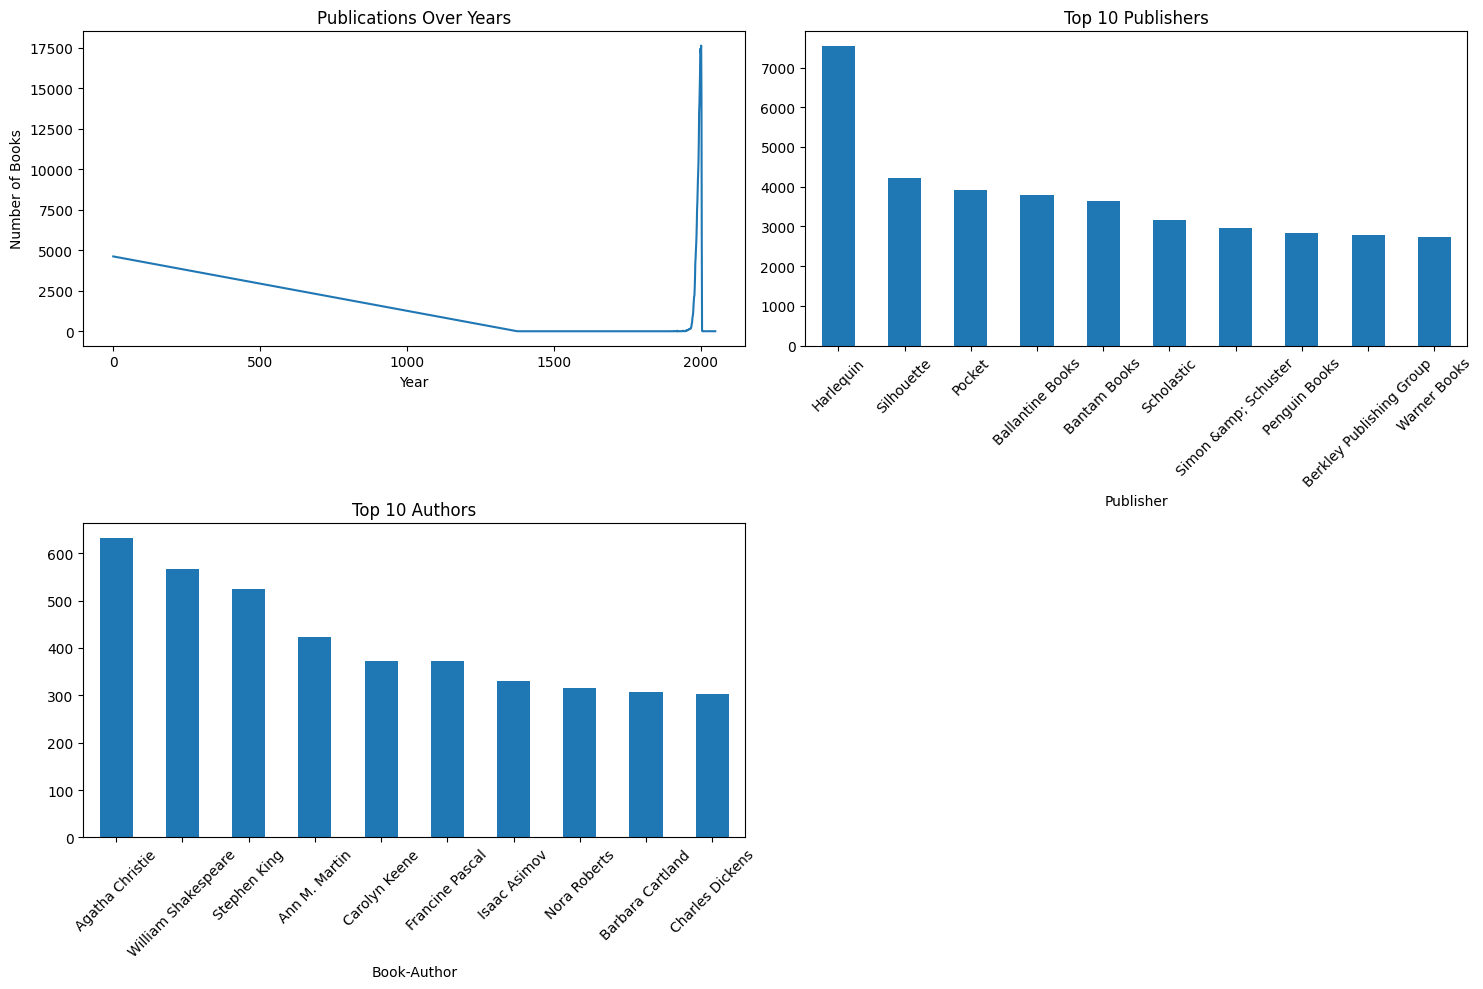


Dataset Statistics:
Total number of books: 271357
Number of unique authors: 102020
Number of unique publishers: 16804
Year range: 0 - 2050

Initializing recommender system...

Book Recommendation Chatbot
Type 'quit' to exit
You: dark
Bot: How can I help you find your next favorite book? You can ask for recommendations based on your interests!
You: Action
Bot: How can I help you find your next favorite book? You can ask for recommendations based on your interests!
You: adventure
Bot: How can I help you find your next favorite book? You can ask for recommendations based on your interests!
You: anything
Bot: How can I help you find your next favorite book? You can ask for recommendations based on your interests!


KeyboardInterrupt: Interrupted by user

In [14]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import os
from datetime import datetime

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab') # Download the missing 'punkt_tab' data


def load_dataset():
    # Download dataset
    path = kagglehub.dataset_download("saurabhbagchi/books-dataset")

    # Find books.csv in the downloaded directory
    csv_path = None
    for root, dirs, files in os.walk(path[0]):
        if 'books.csv' in files:
            csv_path = os.path.join(root, 'books.csv')
            break

    if csv_path is None:
        raise FileNotFoundError("Could not find books.csv in downloaded directory")

    print(f"Loading books.csv from: {csv_path}")

    # Load dataset with error handling
    try:
        books_df = pd.read_csv(
            csv_path,
            encoding='ISO-8859-1',
            delimiter=';',
            on_bad_lines='skip'
        )
    except Exception as e:
        print(f"Error loading dataset: {e}")
        raise

    print("\nDataset loaded successfully!")
    print(f"Number of books: {len(books_df)}")
    print("\nFirst few rows:")
    print(books_df.head())
    return books_df

class TextPreprocessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))

    def preprocess(self, text):
        """Preprocess text by tokenizing, removing stopwords, and lemmatizing."""
        tokens = word_tokenize(str(text).lower())
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens
                 if token.isalnum() and token not in self.stop_words]
        return ' '.join(tokens)

class BookRecommender:
    def __init__(self, books_df):
        self.books_df = books_df
        self.tfidf = TfidfVectorizer(stop_words='english')
        self.tfidf_matrix = None
        self.prepare_features()

    def prepare_features(self):
        """Prepare TF-IDF features from book titles and authors."""
        # Combine title and author for better matching, handling NaN values
        self.books_df['Book-Title'] = self.books_df['Book-Title'].fillna('')  # Replace NaN with empty string in 'Book-Title'
        self.books_df['Book-Author'] = self.books_df['Book-Author'].fillna('')  # Replace NaN with empty string in 'Book-Author'
        combined_features = self.books_df['Book-Title'] + ' ' + self.books_df['Book-Author']
        self.tfidf_matrix = self.tfidf.fit_transform(combined_features)


    def get_recommendations(self, query, n=5):
        """Get book recommendations based on user query."""
        query_vector = self.tfidf.transform([query])
        similarities = cosine_similarity(query_vector, self.tfidf_matrix)
        similar_indices = similarities[0].argsort()[-n:][::-1]
        return self.books_df.iloc[similar_indices]

class ChatHandler:
    def __init__(self, recommender):
        self.recommender = recommender
        self.preprocessor = TextPreprocessor()
        self.conversation_history = []

    def handle_message(self, user_message):
        """Process user message and return appropriate response."""
        processed_message = self.preprocessor.preprocess(user_message)
        self.conversation_history.append(("user", user_message))

        if "recommend" in processed_message or "suggest" in processed_message:
            recommendations = self.recommender.get_recommendations(processed_message)
            response = self.format_recommendations(recommendations)
        else:
            response = "How can I help you find your next favorite book? You can ask for recommendations based on your interests!"

        self.conversation_history.append(("bot", response))
        return response

    def format_recommendations(self, recommendations):
        """Format book recommendations into a readable response."""
        response = "Based on your interests, here are some books you might enjoy:\n\n"
        for _, book in recommendations.iterrows():
            response += f"- {book['Book-Title']} by {book['Book-Author']} ({book['Year-Of-Publication']})\n"
        return response

def analyze_and_visualize(books_df):
    """Create visualizations of the dataset."""
    plt.figure(figsize=(15, 10))

    # Convert 'Year-Of-Publication' to numeric, handling errors
    books_df['Year-Of-Publication'] = pd.to_numeric(books_df['Year-Of-Publication'], errors='coerce')
    # Remove rows with invalid years
    books_df = books_df.dropna(subset=['Year-Of-Publication'])
    # Convert years to integers
    books_df['Year-Of-Publication'] = books_df['Year-Of-Publication'].astype(int)

    # Publications over years
    plt.subplot(2, 2, 1)
    year_counts = books_df['Year-Of-Publication'].value_counts().sort_index()
    year_counts.plot(kind='line')
    plt.title('Publications Over Years')
    plt.xlabel('Year')
    plt.ylabel('Number of Books')

    # ... (rest of the function remains the same)

    # Top publishers
    plt.subplot(2, 2, 2)
    books_df['Publisher'].value_counts().head(10).plot(kind='bar')
    plt.title('Top 10 Publishers')
    plt.xticks(rotation=45)

    # Most prolific authors
    plt.subplot(2, 2, 3)
    books_df['Book-Author'].value_counts().head(10).plot(kind='bar')
    plt.title('Top 10 Authors')
    plt.xticks(rotation=45)

    # Add genre distribution if available
    plt.tight_layout()
    plt.show()

    # Print some statistics
    print("\nDataset Statistics:")
    print(f"Total number of books: {len(books_df)}")
    print(f"Number of unique authors: {books_df['Book-Author'].nunique()}")
    print(f"Number of unique publishers: {books_df['Publisher'].nunique()}")
    print(f"Year range: {books_df['Year-Of-Publication'].min()} - {books_df['Year-Of-Publication'].max()}")

def main():
    # Load dataset
    print("Loading dataset...")
    books_df = load_dataset()

    # Analyze dataset
    print("\nAnalyzing dataset...")
    analyze_and_visualize(books_df)

    # Initialize recommender system
    print("\nInitializing recommender system...")
    recommender = BookRecommender(books_df)
    chat_handler = ChatHandler(recommender)

    # Start chat interface
    print("\nBook Recommendation Chatbot")
    print("Type 'quit' to exit")

    while True:
        user_input = input("You: ")
        if user_input.lower() == 'quit':
            break

        response = chat_handler.handle_message(user_input)
        print(f"Bot: {response}")

if __name__ == "__main__":
    main()